# FER+ Dataset
This notebook will merge information from FER2013 with FER+ to get a complete FER+ dataset with some adjustments.

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
FerPlus = pd.read_csv('datasets/fer2013new.csv')
Fer2013 = pd.read_csv('datasets/fer2013.csv')

In [3]:
print('Shape FER2013:', Fer2013.shape)
Fer2013.head(5)

Shape FER2013: (35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


The emotion labels in FER2013 correspond to:

0=Angry

1=Disgust

2=Fear

3=Happy

4=Sad

5=Surprise

6=Neutral

In [4]:
print('Shape FER+:', FerPlus.shape)
FerPlus.head(5)

Shape FER+: (35887, 12)


,Usage,Image name,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,Training,fer0000000.png,4,0,0,1,3,2,0,0,0,0
1,Training,fer0000001.png,6,0,1,1,0,0,0,0,2,0
2,Training,fer0000002.png,5,0,0,3,1,0,0,0,1,0
3,Training,fer0000003.png,4,0,0,4,1,0,0,0,1,0
4,Training,fer0000004.png,9,0,0,1,0,0,0,0,0,0


FER+ contains 10 human votes per image to which emotion it belongs to (NF = No face).



The FER+ dataset does not contain pixels, and should be taken from FER2013 which exists of the same images.


In [5]:
# Merge datasets
FerPlus['Pixels'] = Fer2013['pixels']
FerPlus['Prev class'] = Fer2013['emotion']
FerPlus['Prev class'] = FerPlus['Prev class'].map({0:'angry', 1:'disgust', 2:'fear', 3:'happy',
                                                   4:'sad', 5:'surprise', 6:'neutral'})
FerPlus = FerPlus.dropna()

# Select emotion with the highest vote count
FerPlus['Class'] = FerPlus[['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt', 'unknown', 'NF']].idxmax(axis=1)
FerPlus['Class int'] = pd.factorize(FerPlus['Class'])[0]
FerPlus['Confidence'] = FerPlus[['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt', 'unknown', 'NF']].max(axis=1)

# Drop rows where the emotion is 'unknown' or no face
FerPlus = FerPlus[FerPlus['Class'] != 'unknown']
FerPlus = FerPlus[FerPlus['Class'] != 'NF']

# Drop unnecessary columns
FerPlus = FerPlus.drop(columns=['Image name'])
FerPlus.reset_index(inplace=True, drop=True)

print('Shape FER+:', FerPlus.shape)
FerPlus.head(5)

Shape FER+: (35488, 16)


,Usage,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF,Pixels,Prev class,Class,Class int,Confidence
0,Training,4,0,0,1,3,2,0,0,0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,angry,neutral,0,4
1,Training,6,0,1,1,0,0,0,0,2,0,151 150 147 155 148 133 111 140 170 174 182 15...,angry,neutral,0,6
2,Training,5,0,0,3,1,0,0,0,1,0,231 212 156 164 174 138 161 173 182 200 106 38...,fear,neutral,0,5
3,Training,4,0,0,4,1,0,0,0,1,0,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,sad,neutral,0,4
4,Training,9,0,0,1,0,0,0,0,0,0,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,neutral,neutral,0,9


The emotion labels (Class int) in FER+ correspond to:

0 = neutral

1 = sadness

2 = happiness

3 = surprise

4 = anger

5 = fear

6 = contempt

7 = disgust


In [6]:
# FerPlus.to_csv('datasets/ferplus.csv', index=False)

# Visualisations

In [7]:
def load_data():
    x = pd.read_csv('datasets/ferplus.csv')

    train_set = x[(x.Usage == 'Training')]
    validation_set = x[(x.Usage == 'PublicTest')]
    test_set = x[(x.Usage == 'PrivateTest')]

    depth = 1
    height = int(sqrt(len(x.Pixels[0].split())))
    width = height

    X_train = np.array(list(map(str.split, train_set.Pixels)), np.float32)
    X_valid = np.array(list(map(str.split, validation_set.Pixels)), np.float32)
    X_test = np.array(list(map(str.split, test_set.Pixels)), np.float32)

    num_train = X_train.shape[0]
    num_validation = X_valid.shape[0]
    num_test = X_test.shape[0]

    X_train = X_train.reshape(num_train, width, height, depth)
    X_valid = X_valid.reshape(num_validation, width, height, depth)
    X_test = X_test.reshape(num_test, width, height, depth)

    def grayscale_to_rgb(images):
        return np.repeat(images, 3, axis=-1)

    X_train = grayscale_to_rgb(X_train)
    X_valid = grayscale_to_rgb(X_valid)
    X_test = grayscale_to_rgb(X_test)

    y_train = train_set['Class int']
    y_valid = validation_set['Class int']
    y_test = test_set['Class int']

    return X_train, y_train, X_valid, y_valid, X_test, y_test

X_train, y_train, X_valid, y_valid, X_test, y_test = load_data()

In [ ]:
print("Shape of train_sample: {}".format(X_train.shape))
print("Shape of train_label: {}".format(y_train.shape))
print("Shape of valid_sample: {}".format(X_valid.shape))
print("Shape of valid_label: {}".format(y_valid.shape))
print("Shape of test_sample: {}".format(X_test.shape))
print("Shape of test_label: {}".format(y_test.shape))

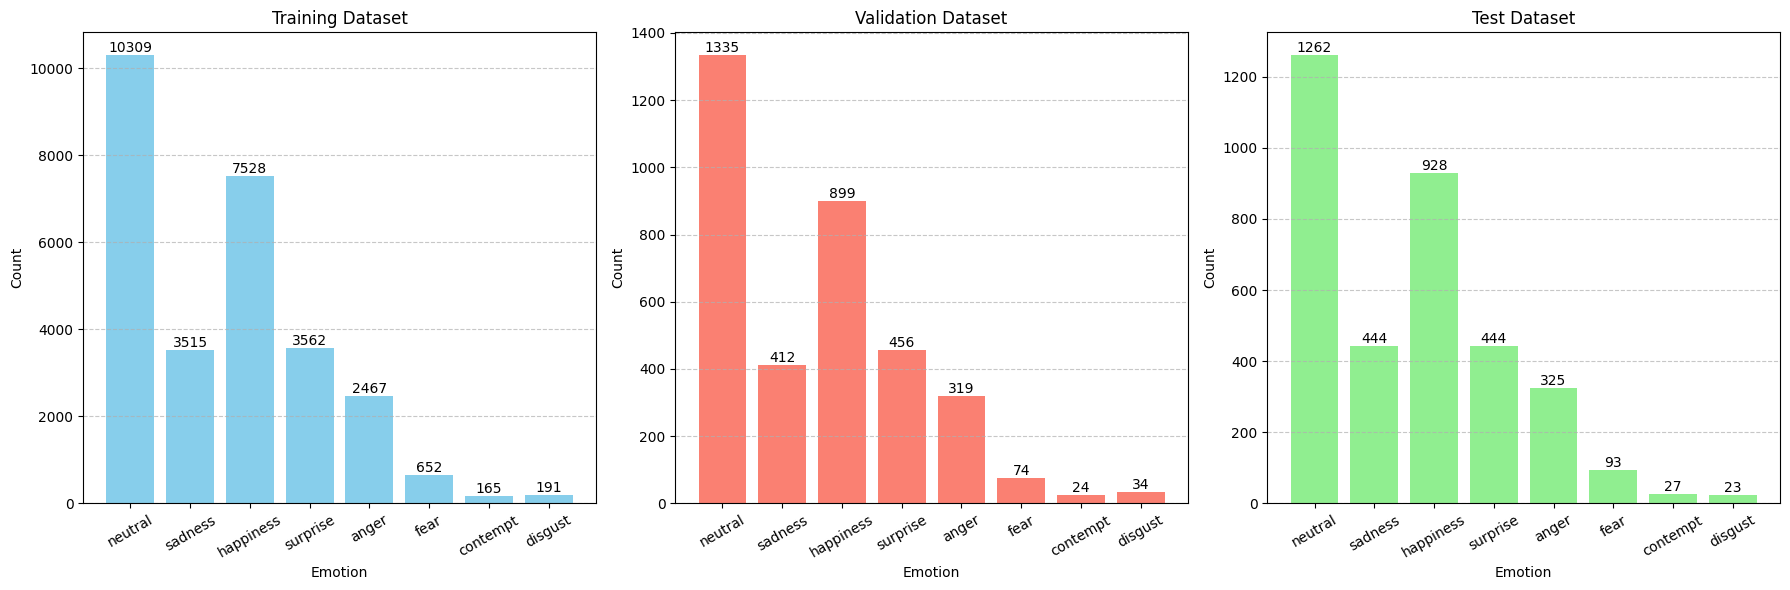

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  

train_counts = Counter(y_train)
valid_counts = Counter(y_valid)
test_counts = Counter(y_test)

class_names = ['neutral', 'sadness', 'happiness', 'surprise', 'anger', 'fear', 'contempt', 'disgust']
class_int = [0, 1, 2, 3, 4, 5, 6, 7]

# Plot histogram for training dataset
train_bars = axes[0].bar(train_counts.keys(), train_counts.values(), color='skyblue')
axes[0].set_xlabel('Emotion')
axes[0].set_ylabel('Count')
axes[0].set_title('Training Dataset')
axes[0].set_xticks(class_int) 
axes[0].set_xticklabels(class_names, rotation=30)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
for bar in train_bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, height, f'{height}', ha='center', va='bottom')

# Plot histogram for validation dataset
valid_bars = axes[1].bar(valid_counts.keys(), valid_counts.values(), color='salmon')
axes[1].set_xlabel('Emotion')
axes[1].set_ylabel('Count')
axes[1].set_title('Validation Dataset')
axes[1].set_xticks(class_int)  
axes[1].set_xticklabels(class_names, rotation=30)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
for bar in valid_bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, height, f'{height}', ha='center', va='bottom')

# Plot histogram for test dataset
test_bars = axes[2].bar(test_counts.keys(), test_counts.values(), color='lightgreen')
axes[2].set_xlabel('Emotion')
axes[2].set_ylabel('Count')
axes[2].set_title('Test Dataset')
axes[2].set_xticks(class_int) 
axes[2].set_xticklabels(class_names, rotation=30)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)
for bar in test_bars:
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2, height, f'{height}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

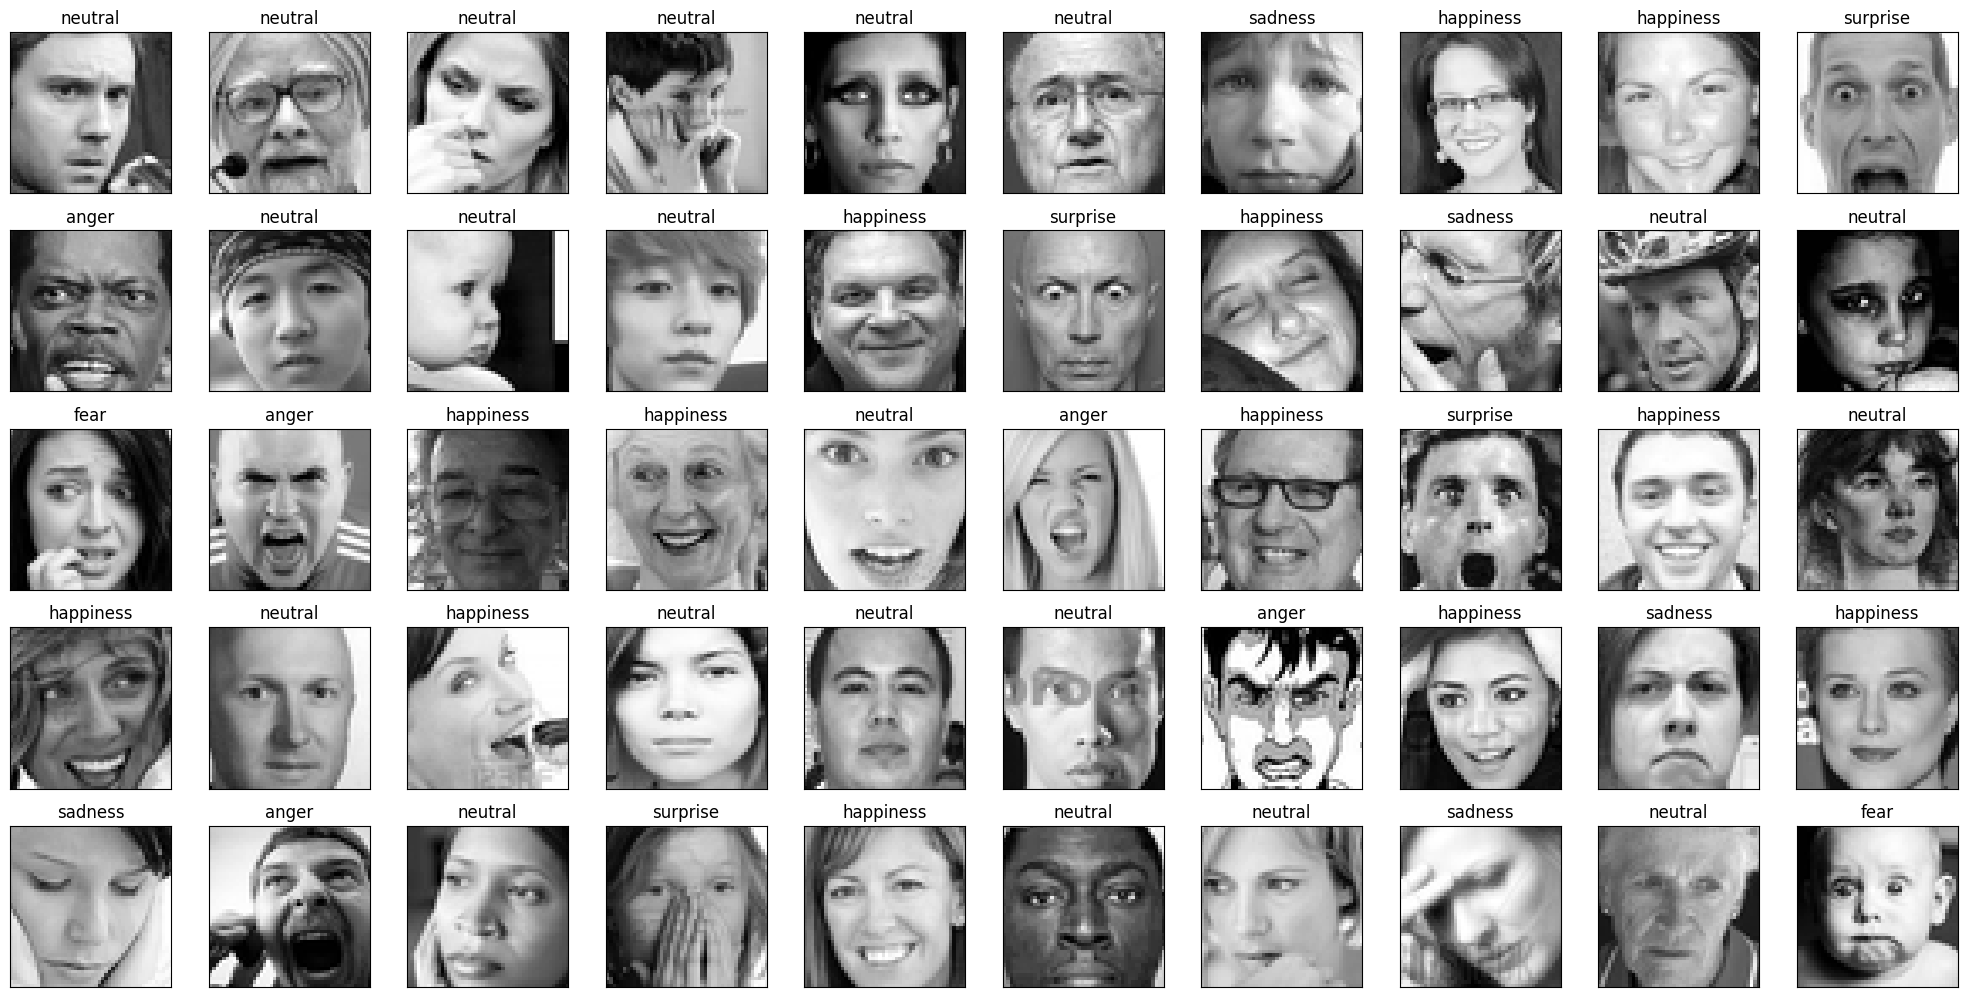

In [10]:
def overview(start, end, X, Y):
    plot_index = 1
    fig = plt.figure(figsize=(20,20))

    for i in range(start, end):
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(10, 10, plot_index)
        ax.imshow(input_img[0,:,:,0], cmap=matplotlib.cm.gray)
        ax.set_title(class_names[Y[i]])
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
        plot_index += 1

    plt.show()

overview(0, 50, X_train, y_train)